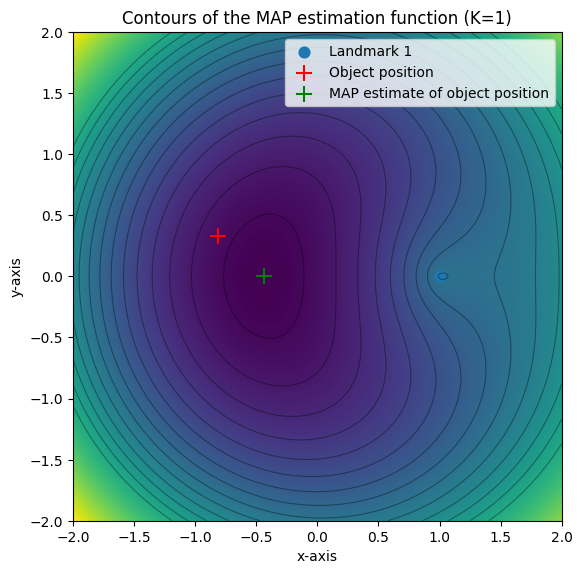

In [4]:
# Q3 — MAP localization (K=1) — full-frame style
import numpy as np, matplotlib.pyplot as plt
rng = np.random.default_rng(42)

sigma_x = sigma_y = 0.25
sigma_r = 0.3
grid_lim = 2.0

# true position (uniform in unit disk)
r = np.sqrt(rng.uniform(0.0, 1.0)); th = rng.uniform(0, 2*np.pi)
x_true, y_true = r*np.cos(th), r*np.sin(th)

def landmarks_on_unit_circle(K):
    ang = np.linspace(0, 2*np.pi, K, endpoint=False)
    return np.c_[np.cos(ang), np.sin(ang)]

def simulate_ranges(xy_true, LM, sigma):
    xy_true = np.array(xy_true, dtype=float).reshape(1, 2)  # robust to tuples
    d_true = np.linalg.norm(LM - xy_true, axis=1)
    r_meas = d_true + rng.normal(0, sigma, size=len(LM))
    neg = r_meas < 0
    while np.any(neg):
        r_meas[neg] = d_true[neg] + rng.normal(0, sigma, size=np.sum(neg))
        neg = r_meas < 0
    return r_meas

K = 1
LM = landmarks_on_unit_circle(K)
r_meas = simulate_ranges((x_true, y_true), LM, sigma_r)

# grid
xs = np.linspace(-grid_lim, grid_lim, 401)
ys = np.linspace(-grid_lim, grid_lim, 401)
XX, YY = np.meshgrid(xs, ys)

# objective J(x,y)
dist = np.sqrt((XX[...,None]-LM[:,0])**2 + (YY[...,None]-LM[:,1])**2)
data_term = np.sum((r_meas - dist)**2, axis=2) / (2*sigma_r**2)
prior_term = 0.5*((XX**2)/(sigma_x**2) + (YY**2)/(sigma_y**2))
JJ = data_term + prior_term

# grid MAP
imin, jmin = np.unravel_index(np.argmin(JJ), JJ.shape)
x_map, y_map = XX[imin, jmin], YY[imin, jmin]

# contour levels (nice range)
Jmin, Jmax = float(JJ.min()), float(JJ.max())
levels = np.linspace(Jmin + 0.02*(Jmax-Jmin), Jmin + 0.6*(Jmax-Jmin), 14)

# full-frame plotting (fills axes; no whitespace)
fig, ax = plt.subplots(figsize=(6.4, 5.6))
ax.imshow(JJ, extent=(xs.min(), xs.max(), ys.min(), ys.max()),
          origin='lower', aspect='equal')
ax.contour(XX, YY, JJ, levels=levels, linewidths=0.8, colors='k', alpha=0.35)

# landmarks (label each)
for i, (lx, ly) in enumerate(LM, start=1):
    ax.scatter([lx], [ly], s=60, label=f"Landmark {i}")
ax.scatter([x_true], [y_true], c='red', marker='+', s=140, label='Object position')
ax.scatter([x_map], [y_map], c='green', marker='+', s=140, label='MAP estimate of object position')

ax.set_xlim(xs.min(), xs.max()); ax.set_ylim(ys.min(), ys.max())
ax.set_xlabel("x-axis"); ax.set_ylabel("y-axis")
ax.set_aspect('equal', adjustable='box')
ax.margins(0)
ax.set_title("Contours of the MAP estimation function (K=1)")
ax.legend(loc='upper right', frameon=True)
fig.tight_layout(pad=0.2)
plt.show()
